# AGM - Company Vision 

### The following proposal has been construtced by the Data Science team in AGM to help achieve the future envisioned by company leaders. This report showcases how we can leverage NoSQL technologies to address key goals.

### The BART system is an essentially transportation system utilized by millions of bay area residents. The Data Science believes this system can be utilized to address several future goals of the company if leveraged properly. Below we have included several forms of analysis we can perform with the help of Neo4J to make key growth decisions.

### Thousands of commuters utilize the BART to travel all around the city. It only makes sense to provide our customers with ability to shop for food and groceries at the most convenient places, during their everyday commutes. To accomplish this, we can construct a small-world, weighted, non-directional graph representing the current layout of the BART system.

## BART Map
This graph gives us a visual indication of how vast and wide spread the BART system is.

![Bart Map](bart_map.png)

In [1]:
!pip install geopandas contextily graphdatascience osmnx

In [2]:
%run agm_functions.py
import matplotlib.pyplot as plt
graph_algos = GraphAlgos('weight')

## Create a directed acyclic graph (DAG) with one-way relationships between stations

In [3]:
graph_algos.create_dag()

,nodes,relationships,density
0,50,108,0.0882


## Plot the DAG on a map using the station geolocations

/user/projects/project-3-kkasravi/code/agm_functions.py:509: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.connection)


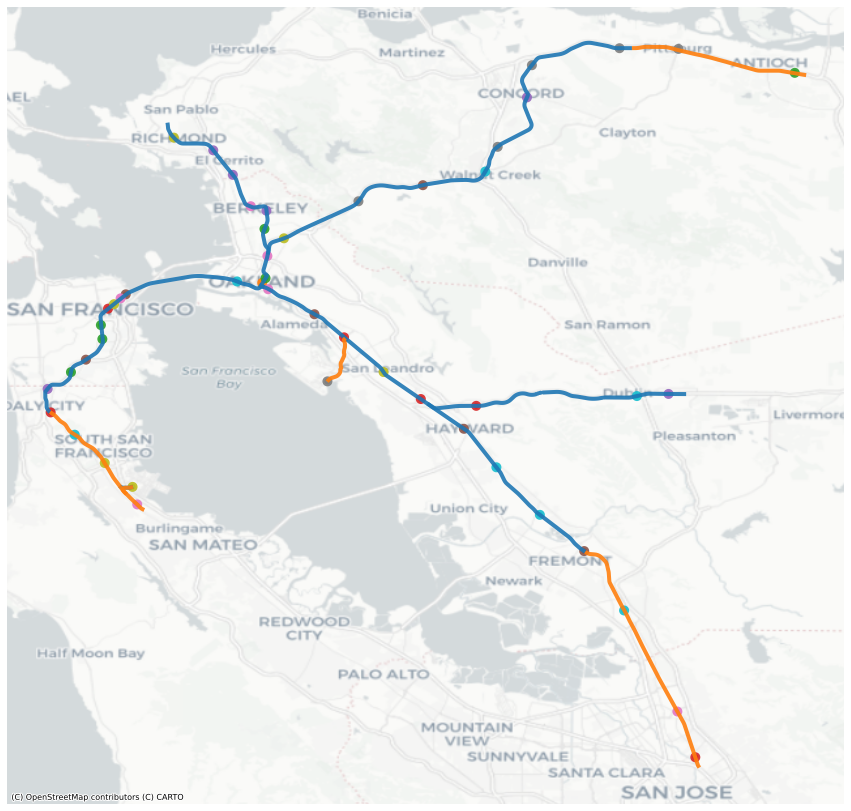

In [4]:
graph_algos.plot_map()

## Using this graph we can determine the closeness centrality algorithm to identify stations that can be ideal candidates for NEW KITCHENS.

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 [Text(-10.0, 0, 'Daly City'),
  Text(0.0, 0, 'El Cerrito del Norte'),
  Text(10.0, 0, 'Ashby'),
  Text(20.0, 0, 'Fruitvale'),
  Text(30.0, 0, 'Union City'),
  Text(40.0, 0, 'Daly City'),
  Text(50.0, 0, ''),
  Text(60.0, 0, '')])

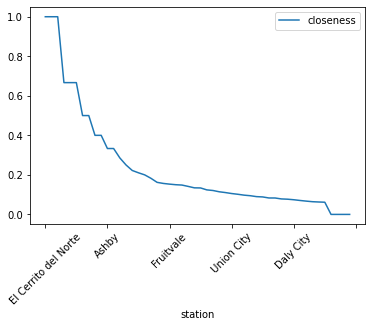

In [5]:
graph_algos.get_best_kitchen_locations().plot(x="station", y="closeness")
plt.xticks(rotation=45)

## Using this graph we can determine the betweenness centrality algorithm to identify stations that can be ideal candidates for COMMUTERS.

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 [Text(-10.0, 0, 'Pittsburg Center'),
  Text(0.0, 0, 'West Oakland'),
  Text(10.0, 0, 'Civic Center'),
  Text(20.0, 0, 'Orinda'),
  Text(30.0, 0, 'South San Francisco'),
  Text(40.0, 0, 'Pittsburg Center'),
  Text(50.0, 0, ''),
  Text(60.0, 0, '')])

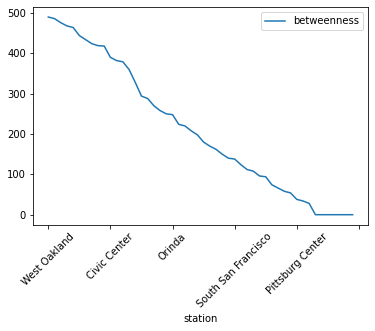

In [6]:
graph_algos.get_best_commuter_locations().plot(x="station", y="betweenness")
plt.xticks(rotation=45)

### These stations act as bridges and have a high influence over the flow. Given these stations serve as bridges in the transit system, placing stores or pickup locations can add conveince for our customers. They can simply pick up their meals on their way to work or home


## zipcode population by station

/user/projects/project-3-kkasravi/code/agm_functions.py:509: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.connection)


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 [Text(-10.0, 0, 'Antioch'),
  Text(0.0, 0, 'Civic Center'),
  Text(10.0, 0, 'Daly City'),
  Text(20.0, 0, 'Coliseum'),
  Text(30.0, 0, 'Pleasant Hill'),
  Text(40.0, 0, 'Antioch'),
  Text(50.0, 0, ''),
  Text(60.0, 0, '')])

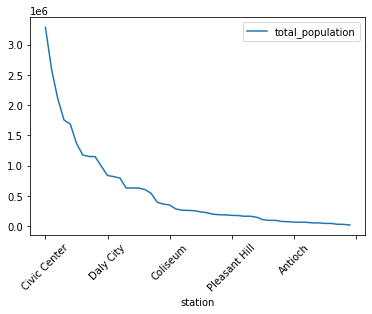

In [13]:
graph_algos.get_zipcode_population_by_station(miles=2.1).plot(x="station", y="total_population")
plt.xticks(rotation=45)

In [14]:
# for each station, get a list of zip codes and then the total number of customers in each of those zip codes
stations = graph_algos.get_stations()['station']
station_zips = {}

for station in stations:
    # grab a list of all zips near a 1 mile radius of the station - Example berkeley Store
    zip_codes, populations, total_populations = graph_algos.station_get_zips(station, miles=2.1)
    zip_and_customer_pop = []

    # how many customers live in each of those zip codes
    for zip in zip_codes:
        zip_pop = {}
        query = """
        select count(customer_id) as total_number_of_customers, zip
        from customers
        where zip like '{}'
        group by zip
        """.format(zip)

        graph_algos.cursor.execute(query)
        graph_algos.connection.rollback()
        result = ','.join([str(row[0]) for row in graph_algos.cursor.fetchall()])
        zip_pop = {zip: result}
        zip_and_customer_pop.append(zip_pop)
        
    
    station_zips[station] = zip_and_customer_pop
    

/user/projects/project-3-kkasravi/code/agm_functions.py:509: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, self.connection)


In [15]:
# Given the info in station_zips, create a node for zip type and link to station with weight of customer pop

for station in station_zips:
    # create a node for each zip code
    for zip in station_zips[station]:
        zip_code = list(zip.keys())[0]
        customer_pop = list(zip.values())[0]
        query = """
    
        CREATE (:Zip {name: $station_name})
    
        """

        graph_algos.session.run(query, station_name=zip_code)
        
        # create a link to the original station node
        query = """MATCH (from:Zip),
                     (to:Station)
        WHERE from.name = $from_station and to.name = $to_station
        CREATE (from)-[:LINK {weight: $weight}]->(to)"""
        graph_algos.session.run(query, from_station=zip_code, to_station=station, weight=customer_pop)
        
        
        
graph_algos.number_nodes_relationships()

,nodes,relationships,density
0,504,1949,0.0154


## With the updated graph, we can find the nodes with the highest degree centrality. These stations would be great candidates for HOME DELIVERY

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 [Text(-10.0, 0, 'North Concord'),
  Text(0.0, 0, '16th Street Mission'),
  Text(10.0, 0, '19th Street'),
  Text(20.0, 0, 'Downtown Berkeley'),
  Text(30.0, 0, 'South San Francisco'),
  Text(40.0, 0, 'North Concord'),
  Text(50.0, 0, ''),
  Text(60.0, 0, '')])

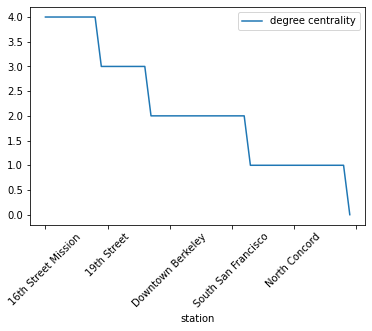

In [16]:
graph_algos.get_best_delivery_locations().plot(x="station", y="degree centrality")
plt.xticks(rotation=45)

## With Neo4j, we have tools available that we can use to determine the shortest path from one point to another through the BART system. This can provide us with important information to make the commute and delivery process more efficent 

In [11]:
graph_algos.shortest_path('12th Street', '16th Street Mission')


--------------------------------
   Total Cost:  1140
   Minutes:  19.0
--------------------------------
12th Street, 0, 0
West Oakland, 300, 300
Embarcadero, 420, 720
Montgomery Street, 60, 780
Powell Street, 120, 900
Civic Center, 60, 960
16th Street Mission, 180, 1140


## We can further extrapolate the results obtained from the graph algos and determine information about the average and std deviation for each of the scores.

In [12]:
graph_algos.get_avg_stddev()

                                             Degree Centrality  Closeness Centrality  Betweenness Centrality
                                   Average                 2.16                 0.24               212.92
                        Standard Deviation                 1.13                 0.26               163.17
